# Data Wrangling : We `RateDogs` Twitter Data

## Importing required libraries

In [1]:
import os
import pandas as pd
import numpy as np
import requests
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import seaborn
import re


## Gather Data

### Twitter archive

In [2]:
# Reading CSV file
df_archive = pd.read_csv('twitter-archive-enhanced.csv')

### Image prediction

In [3]:
# Downloading URL
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
r = requests.get(url)

with open ('image-predictions.tsv',mode='wb') as file:
    file.write(r.content)
    
# Reading TSV file 
df_image_prediction = pd.read_csv('image-predictions.tsv',sep='\t')


### Twitter API & JSON

In [4]:
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

# function to get the data from twitter api
def get_twitter_data(df, file_path):
    """
    get_twitter_data: function to get twitter data using tweepy library
    to access twitter API.
    ARGS:
        df: a pandas data frame which stores the tweets ids in tweet_id column.
        file_path: a file path for the file to save the retrived data in.
    Return: nothing
    """
    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_secret)

    api = tweepy.API(auth, wait_on_rate_limit=True)

    # Tweet IDs for which to gather additional data via Twitter's API
    tweet_ids = df.tweet_id.values
    len(tweet_ids)

    # Query Twitter's API for JSON data for each tweet ID in the Twitter archive
    count = 0
    fails_dict = {}
    start = timer()
    # Save each tweet's returned JSON as a new line in a .txt file
    with open(file_path, 'w') as outfile:
        # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
        for tweet_id in tweet_ids:
            count += 1
            print(str(count) + ": " + str(tweet_id))
            try:
                tweet = api.get_status(tweet_id, tweet_mode='extended')
                print("Success")
                json.dump(tweet._json, outfile)
                outfile.write('\n')
            except tweepy.TweepError as e:
                print("Fail")
                fails_dict[tweet_id] = e
                pass
    end = timer()
    print(end - start)
    print(fails_dict)

In [5]:
# Download data from twitter API 
if not os.path.exists('tweet-json.txt'):
    get_twitter_data(df_archive, 'tweet-json.txt')

In [6]:
# Load tweets data into pandas df
with open('tweet-json.txt') as file:
    df_api = pd.read_json(file, lines= True, encoding = 'utf-8')
    


## Assess Data

### Inspecting the dataset for two things :
- Data quality issues 
- Tidiness issues 

### Twitter archive

#### Visual assessment

In [7]:
df_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


#### Programmatic assessment

In [8]:
df_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [9]:
df_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [10]:
sum(df_archive.duplicated())

0

In [11]:
df_archive['text'][0]

"This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU"

In [12]:
df_archive['source'][0]

'<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>'

In [13]:
df_archive[[ 'doggo', 'floofer', 'pupper', 'puppo']]

,doggo,floofer,pupper,puppo
0,None,None,None,None
1,None,None,None,None
2,None,None,None,None
3,None,None,None,None
4,None,None,None,None
5,None,None,None,None
6,None,None,None,None
7,None,None,None,None
8,None,None,None,None
9,doggo,None,None,None


In [14]:
df_archive['name'].value_counts()

None       745
a           55
Charlie     12
Lucy        11
Cooper      11
Oliver      11
Lola        10
Penny       10
Tucker      10
Winston      9
Bo           9
the          8
Sadie        8
Daisy        7
Buddy        7
an           7
Toby         7
Bailey       7
Bella        6
Milo         6
Leo          6
Dave         6
Oscar        6
Rusty        6
Scout        6
Stanley      6
Koda         6
Jack         6
Jax          6
Gus          5
          ... 
Kulet        1
Ralphé       1
Willem       1
Yukon        1
Katie        1
Rumble       1
Binky        1
Damon        1
Tebow        1
Dex          1
Rambo        1
Karll        1
Blue         1
Marty        1
Kane         1
Sid          1
Covach       1
Kona         1
Zuzu         1
Brooks       1
Livvie       1
Petrick      1
Mary         1
Millie       1
Ferg         1
Tassy        1
Dallas       1
Duddles      1
Pherb        1
Jiminus      1
Name: name, Length: 957, dtype: int64

In [15]:
df_archive['name'].unique()

array(['Phineas', 'Tilly', 'Archie', 'Darla', 'Franklin', 'None', 'Jax',
       'Zoey', 'Cassie', 'Koda', 'Bruno', 'Ted', 'Stuart', 'Oliver', 'Jim',
       'Zeke', 'Ralphus', 'Canela', 'Gerald', 'Jeffrey', 'such', 'Maya',
       'Mingus', 'Derek', 'Roscoe', 'Waffles', 'Jimbo', 'Maisey', 'Lilly',
       'Earl', 'Lola', 'Kevin', 'Yogi', 'Noah', 'Bella', 'Grizzwald',
       'Rusty', 'Gus', 'Stanley', 'Alfy', 'Koko', 'Rey', 'Gary', 'a',
       'Elliot', 'Louis', 'Jesse', 'Romeo', 'Bailey', 'Duddles', 'Jack',
       'Emmy', 'Steven', 'Beau', 'Snoopy', 'Shadow', 'Terrance', 'Aja',
       'Penny', 'Dante', 'Nelly', 'Ginger', 'Benedict', 'Venti', 'Goose',
       'Nugget', 'Cash', 'Coco', 'Jed', 'Sebastian', 'Walter', 'Sierra',
       'Monkey', 'Harry', 'Kody', 'Lassie', 'Rover', 'Napolean', 'Dawn',
       'Boomer', 'Cody', 'Rumble', 'Clifford', 'quite', 'Dewey', 'Scout',
       'Gizmo', 'Cooper', 'Harold', 'Shikha', 'Jamesy', 'Lili', 'Sammy',
       'Meatball', 'Paisley', 'Albus', 'Neptune', '

In [16]:
df_archive[df_archive['name'].str.islower()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
22,887517139158093824,NaN,NaN,2017-07-19 03:39:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I've yet to rate a Venezuelan Hover Wiener. Th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887517139...,14,10,such,None,None,None,None
56,881536004380872706,NaN,NaN,2017-07-02 15:32:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a pupper approaching maximum borkdrive...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/881536004...,14,10,a,None,None,pupper,None
118,869988702071779329,NaN,NaN,2017-05-31 18:47:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: We only rate dogs. This is quit...,8.591970e+17,4.196984e+09,2017-05-02 00:04:57 +0000,https://twitter.com/dog_rates/status/859196978...,12,10,quite,None,None,None,None
169,859196978902773760,NaN,NaN,2017-05-02 00:04:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",We only rate dogs. This is quite clearly a smo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/859196978...,12,10,quite,None,None,None,None
193,855459453768019968,NaN,NaN,2017-04-21 16:33:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Guys, we only rate dogs. This is quite clearly...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/855459453...,12,10,quite,None,None,None,None
335,832645525019123713,NaN,NaN,2017-02-17 17:38:57 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",There's going to be a dog terminal at JFK Airp...,NaN,NaN,NaN,http://us.blastingnews.com/news/2017/02/jfk-an...,10,10,not,None,None,None,None
369,828650029636317184,NaN,NaN,2017-02-06 17:02:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Occasionally, we're sent fantastic stories. Th...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/828650029...,14,10,one,None,None,None,None
542,806219024703037440,NaN,NaN,2016-12-06 19:29:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",We only rate dogs. Please stop sending in non-...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/806219024...,11,10,incredibly,None,None,None,None
649,792913359805018113,NaN,NaN,2016-10-31 02:17:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a perfect example of someone who has t...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/792913359...,13,10,a,None,None,None,None
682,788552643979468800,NaN,NaN,2016-10-19 01:29:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Say hello to mad pupper. You kn...,7.363926e+17,4.196984e+09,2016-05-28 03:04:00 +0000,"https://vine.co/v/iEggaEOiLO3,https://vine.co/...",13,10,mad,None,None,pupper,None


In [17]:
df_archive[['rating_numerator','rating_denominator']].describe()

,rating_numerator,rating_denominator
count,2356.000000,2356.000000
mean,13.126486,10.455433
std,45.876648,6.745237
min,0.000000,0.000000
25%,10.000000,10.000000
50%,11.000000,10.000000
75%,12.000000,10.000000
max,1776.000000,170.000000


In [18]:
df_archive[df_archive['rating_numerator'] > 10]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [19]:
df_archive[df_archive['rating_denominator'] > 10]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
342,832088576586297345,8.320875e+17,3.058208e+07,2017-02-16 04:45:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@docmisterio account started on 11/15/15,NaN,NaN,NaN,NaN,11,15,None,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: After so many requests, this is...",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244...,165,150,None,None,None,None,None
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to this unbelievably well behaved sq...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023...,204,170,this,None,None,None,None
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy 4/20 from the squad! 13/10 for all https...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582...,4,20,None,None,None,None,None
1202,716439118184652801,NaN,NaN,2016-04-03 01:36:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bluebert. He just saw that both #Final...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/716439118...,50,50,Bluebert,None,None,None,None
1228,713900603437621249,NaN,NaN,2016-03-27 01:29:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy Saturday here's 9 puppers on a bench. 99...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/713900603...,99,90,None,None,None,None,None
1254,710658690886586372,NaN,NaN,2016-03-18 02:46:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a brigade of puppers. All look very pre...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/710658690...,80,80,None,None,None,None,None


### Image prediction

#### Visual assessment

In [20]:
df_image_prediction

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


#### Programmatic assessment

In [21]:
df_image_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [22]:
df_image_prediction.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [23]:
# Checking for duplicate 
sum(df_image_prediction.duplicated())

0

In [24]:
df_image_prediction['img_num'].value_counts()

1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

In [25]:
df_image_prediction['p1'].unique()

array(['Welsh_springer_spaniel', 'redbone', 'German_shepherd',
       'Rhodesian_ridgeback', 'miniature_pinscher', 'Bernese_mountain_dog',
       'box_turtle', 'chow', 'shopping_cart', 'miniature_poodle',
       'golden_retriever', 'Gordon_setter', 'Walker_hound', 'pug',
       'bloodhound', 'Lhasa', 'English_setter', 'hen', 'desktop_computer',
       'Italian_greyhound', 'Maltese_dog', 'three-toed_sloth', 'ox',
       'malamute', 'guinea_pig', 'soft-coated_wheaten_terrier',
       'Chihuahua', 'black-and-tan_coonhound', 'coho', 'toy_terrier',
       'Blenheim_spaniel', 'Pembroke', 'llama', 'Chesapeake_Bay_retriever',
       'curly-coated_retriever', 'dalmatian', 'Ibizan_hound',
       'Border_collie', 'Labrador_retriever', 'seat_belt', 'snail',
       'miniature_schnauzer', 'Airedale', 'triceratops', 'swab', 'hay',
       'hyena', 'jigsaw_puzzle', 'West_Highland_white_terrier',
       'toy_poodle', 'giant_schnauzer', 'vizsla', 'vacuum', 'Rottweiler',
       'Siberian_husky', 'teddy', 

In [26]:
df_image_prediction['p2'].unique()

array(['collie', 'miniature_pinscher', 'malinois', 'redbone', 'Rottweiler',
       'English_springer', 'mud_turtle', 'Tibetan_mastiff',
       'shopping_basket', 'komondor', 'Yorkshire_terrier',
       'English_foxhound', 'bull_mastiff', 'German_shepherd', 'Shih-Tzu',
       'Newfoundland', 'cock', 'desk', 'toy_terrier', 'toy_poodle',
       'otter', 'Chesapeake_Bay_retriever', 'Siberian_husky', 'skunk',
       'Afghan_hound', 'bloodhound', 'barracouta', 'papillon',
       'cocker_spaniel', 'chow', 'Irish_terrier', 'chain_saw', 'beagle',
       'giant_schnauzer', 'Labrador_retriever', 'Pembroke', 'Chihuahua',
       'Weimaraner', 'slug', 'Brittany_spaniel', 'standard_schnauzer',
       'teddy', 'armadillo', 'African_hunting_dog', 'vizsla', 'doormat',
       'pug', 'Italian_greyhound', 'Samoyed', 'Pomeranian',
       'miniature_poodle', 'Lakeland_terrier', 'Irish_setter', 'swab',
       'malamute', 'bath_towel', 'Border_collie', 'Leonberg', 'drake',
       'French_bulldog', 'ice_bear', 

In [27]:
df_image_prediction['p3'].unique()

array(['Shetland_sheepdog', 'Rhodesian_ridgeback', 'bloodhound',
       'miniature_pinscher', 'Doberman', 'Greater_Swiss_Mountain_dog',
       'terrapin', 'fur_coat', 'golden_retriever',
       'soft-coated_wheaten_terrier', 'Labrador_retriever', 'Pekinese',
       'Ibizan_hound', 'French_bulldog', 'malinois', 'Dandie_Dinmont',
       'borzoi', 'partridge', 'bookcase', 'basenji', 'miniature_poodle',
       'great_grey_owl', 'groenendael', 'Eskimo_dog', 'hamster', 'briard',
       'papillon', 'flat-coated_retriever', 'gar', 'Chihuahua', 'Shih-Tzu',
       'Pomeranian', 'dingo', 'power_drill', 'Saluki', 'Great_Pyrenees',
       'West_Highland_white_terrier', 'collie', 'toy_poodle', 'vizsla',
       'acorn', 'giant_schnauzer', 'teddy', 'common_iguana', 'wig',
       'water_buffalo', 'coyote', 'seat_belt', 'kelpie', 'space_heater',
       'Brabancon_griffon', 'standard_poodle', 'beagle',
       'Irish_water_spaniel', 'bluetick', 'Weimaraner',
       'Chesapeake_Bay_retriever', 'toilet_tiss

In [28]:
df_image_prediction[['p1_conf','p2_conf','p3_conf']].describe()

,p1_conf,p2_conf,p3_conf
count,2075.000000,2.075000e+03,2.075000e+03
mean,0.594548,1.345886e-01,6.032417e-02
std,0.271174,1.006657e-01,5.090593e-02
min,0.044333,1.011300e-08,1.740170e-10
25%,0.364412,5.388625e-02,1.622240e-02
50%,0.588230,1.181810e-01,4.944380e-02
75%,0.843855,1.955655e-01,9.180755e-02
max,1.000000,4.880140e-01,2.734190e-01


In [29]:
df_image_prediction.loc[(df_image_prediction['p1_dog'] == False) & 
                        (df_image_prediction['p2_dog'] == False) &
                        (df_image_prediction['p3_dog'] == False)
                       ]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,4.588540e-02,False,terrapin,1.788530e-02,False
17,666104133288665088,https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg,1,hen,0.965932,False,cock,3.391940e-02,False,partridge,5.206580e-05,False
18,666268910803644416,https://pbs.twimg.com/media/CT8QCd1WEAADXws.jpg,1,desktop_computer,0.086502,False,desk,8.554740e-02,False,bookcase,7.947970e-02,False
21,666293911632134144,https://pbs.twimg.com/media/CT8mx7KW4AEQu8N.jpg,1,three-toed_sloth,0.914671,False,otter,1.525000e-02,False,great_grey_owl,1.320720e-02,False
25,666362758909284353,https://pbs.twimg.com/media/CT9lXGsUcAAyUFt.jpg,1,guinea_pig,0.996496,False,skunk,2.402450e-03,False,hamster,4.608630e-04,False
29,666411507551481857,https://pbs.twimg.com/media/CT-RugiWIAELEaq.jpg,1,coho,0.404640,False,barracouta,2.714850e-01,False,gar,1.899450e-01,False
45,666786068205871104,https://pbs.twimg.com/media/CUDmZIkWcAAIPPe.jpg,1,snail,0.999888,False,slug,5.514170e-05,False,acorn,2.625800e-05,False
50,666837028449972224,https://pbs.twimg.com/media/CUEUva1WsAA2jPb.jpg,1,triceratops,0.442113,False,armadillo,1.140710e-01,False,common_iguana,4.325530e-02,False
51,666983947667116034,https://pbs.twimg.com/media/CUGaXDhW4AY9JUH.jpg,1,swab,0.589446,False,chain_saw,1.901420e-01,False,wig,3.450970e-02,False
53,667012601033924608,https://pbs.twimg.com/media/CUG0bC0U8AAw2su.jpg,1,hyena,0.987230,False,African_hunting_dog,1.260080e-02,False,coyote,5.735010e-05,False


### API file

#### Visual assessment

In [30]:
df_api

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,possibly_sensitive_appealable,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,truncated,user
0,NaN,NaN,2017-08-01 16:23:56,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...",39467,False,This is Phineas. He's a mystical boy. Only eve...,NaN,...,0.0,NaN,NaN,NaN,8853,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1,NaN,NaN,2017-08-01 00:17:27,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...",33819,False,This is Tilly. She's just checking pup on you....,NaN,...,0.0,NaN,NaN,NaN,6514,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
2,NaN,NaN,2017-07-31 00:18:03,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...",25461,False,This is Archie. He is a rare Norwegian Pouncin...,NaN,...,0.0,NaN,NaN,NaN,4328,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
3,NaN,NaN,2017-07-30 15:58:51,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...",42908,False,This is Darla. She commenced a snooze mid meal...,NaN,...,0.0,NaN,NaN,NaN,8964,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
4,NaN,NaN,2017-07-29 16:00:24,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...",41048,False,This is Franklin. He would like you to stop ca...,NaN,...,0.0,NaN,NaN,NaN,9774,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
5,NaN,NaN,2017-07-29 00:08:17,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891087942176911360, 'id_str'...",20562,False,Here we have a majestic great white breaching ...,NaN,...,0.0,NaN,NaN,NaN,3261,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
6,NaN,NaN,2017-07-28 16:27:12,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 890971906207338496, 'id_str'...",12041,False,Meet Jax. He enjoys ice cream so much he gets ...,NaN,...,0.0,NaN,NaN,NaN,2158,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
7,NaN,NaN,2017-07-28 00:22:40,"[0, 118]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 890729118844600320, 'id_str'...",56848,False,When you watch your owner call another dog a g...,NaN,...,0.0,NaN,NaN,NaN,16716,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
8,NaN,NaN,2017-07-27 16:25:51,"[0, 122]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 890609177319665665, 'id_str'...",28226,False,This is Zoey. She doesn't want to be one of th...,NaN,...,0.0,NaN,NaN,NaN,4429,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
9,NaN,NaN,2017-07-26 15:59:51,"[0, 133]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 890240245463175168, 'id_str'...",32467,False,This is Cassie. She is a college pup. Studying...,NaN,...,0.0,NaN,NaN,NaN,7711,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


#### Programmatic assessment

In [31]:
df_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 31 columns):
contributors                     0 non-null float64
coordinates                      0 non-null float64
created_at                       2354 non-null datetime64[ns]
display_text_range               2354 non-null object
entities                         2354 non-null object
extended_entities                2073 non-null object
favorite_count                   2354 non-null int64
favorited                        2354 non-null bool
full_text                        2354 non-null object
geo                              0 non-null float64
id                               2354 non-null int64
id_str                           2354 non-null int64
in_reply_to_screen_name          78 non-null object
in_reply_to_status_id            78 non-null float64
in_reply_to_status_id_str        78 non-null float64
in_reply_to_user_id              78 non-null float64
in_reply_to_user_id_str          78 n

In [32]:
df_api.describe()

,contributors,coordinates,favorite_count,geo,id,id_str,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,possibly_sensitive,possibly_sensitive_appealable,quoted_status_id,quoted_status_id_str,retweet_count
count,0.0,0.0,2354.000000,0.0,2.354000e+03,2.354000e+03,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,2211.0,2211.0,2.900000e+01,2.900000e+01,2354.000000
mean,NaN,NaN,8080.968564,NaN,7.426978e+17,7.426978e+17,7.455079e+17,7.455079e+17,2.014171e+16,2.014171e+16,0.0,0.0,8.162686e+17,8.162686e+17,3164.797366
std,NaN,NaN,11814.771334,NaN,6.852812e+16,6.852812e+16,7.582492e+16,7.582492e+16,1.252797e+17,1.252797e+17,0.0,0.0,6.164161e+16,6.164161e+16,5284.770364
min,NaN,NaN,0.000000,NaN,6.660209e+17,6.660209e+17,6.658147e+17,6.658147e+17,1.185634e+07,1.185634e+07,0.0,0.0,6.721083e+17,6.721083e+17,0.000000
25%,NaN,NaN,1415.000000,NaN,6.783975e+17,6.783975e+17,6.757419e+17,6.757419e+17,3.086374e+08,3.086374e+08,0.0,0.0,7.888183e+17,7.888183e+17,624.500000
50%,NaN,NaN,3603.500000,NaN,7.194596e+17,7.194596e+17,7.038708e+17,7.038708e+17,4.196984e+09,4.196984e+09,0.0,0.0,8.340867e+17,8.340867e+17,1473.500000
75%,NaN,NaN,10122.250000,NaN,7.993058e+17,7.993058e+17,8.257804e+17,8.257804e+17,4.196984e+09,4.196984e+09,0.0,0.0,8.664587e+17,8.664587e+17,3652.000000
max,NaN,NaN,132810.000000,NaN,8.924206e+17,8.924206e+17,8.862664e+17,8.862664e+17,8.405479e+17,8.405479e+17,0.0,0.0,8.860534e+17,8.860534e+17,79515.000000


### Observation 

#### Quality 
- `source` column is  we can extract the source of the tweet and covert it to categorical.
- `text` column has `the link for the tweets` and `ratings` at the end we can remove it.
- Columns `(doggo, floofer, pupper, puppo)` has None for missing values.
- `name` column have None instead of NaN and too many unvalid values.
- `timestamp` column is str instead of datetime
- We are interested in the `tweet ONLY` not the `retweet` there for we should remove those from the table.
- We are interested in the `tweet ONLY` not the `reply to the original tweet` there for we should remove those from the table.
- `rating_denominator` column has values less than 10 and values more than 10 for ratings more than one dog.
- Column `expanded_urls` has missing values are for tweets without photo

#### Tidiness
- `doggo`, `floofer`, `pupper`, `puppo` columns are all about the same things, `dog stage`.
- Column `img_num` useless
- Columns `(p1,p2,p3)` combine them in column `doy_type` and Columns `(p1_conf,p2_conf,p3_conf)` combine them in column `p_confidence`
- Just 3 columns needed `id`, `retweet_count`, `favorite_count`
- Combine all dataset in `df_data`



## Clean Data

### Take a copy from our data to work on  cleaning it

In [33]:
df_archive_clean = df_archive.copy()
df_image_prediction_clean = df_image_prediction.copy()
df_api_clean = df_api.copy()

### Quality Issues 

#### Define

Extract the source of the tweet fron `source` column and covert by using `apply` method.

#### Code

In [34]:
df_archive_clean['source'][0]

'<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>'

In [35]:
def fix_source(x):
    i = x.find('>')+1
    j = x[i:].find('<')
    return x[i:][:j]

In [36]:
df_archive_clean['source']= df_archive_clean['source'].apply(lambda x : fix_source(x))

#### Test

In [37]:
df_archive_clean['source'].sample(10)

1167    Twitter for iPhone
1522    Twitter for iPhone
1334    Twitter for iPhone
428     Twitter for iPhone
2271    Twitter Web Client
133     Twitter for iPhone
147     Twitter for iPhone
391     Twitter for iPhone
774     Twitter for iPhone
196     Twitter for iPhone
Name: source, dtype: object

#### Define

Remove `Link of tweets` and `Rating` from `text` column   

#### Code

In [38]:
df_archive_clean.text

0       This is Phineas. He's a mystical boy. Only eve...
1       This is Tilly. She's just checking pup on you....
2       This is Archie. He is a rare Norwegian Pouncin...
3       This is Darla. She commenced a snooze mid meal...
4       This is Franklin. He would like you to stop ca...
5       Here we have a majestic great white breaching ...
6       Meet Jax. He enjoys ice cream so much he gets ...
7       When you watch your owner call another dog a g...
8       This is Zoey. She doesn't want to be one of th...
9       This is Cassie. She is a college pup. Studying...
10      This is Koda. He is a South Australian decksha...
11      This is Bruno. He is a service shark. Only get...
12      Here's a puppo that seems to be on the fence a...
13      This is Ted. He does his best. Sometimes that'...
14      This is Stuart. He's sporting his favorite fan...
15      This is Oliver. You're witnessing one of his m...
16      This is Jim. He found a fren. Taught him how t...
17      This i

In [39]:
df_archive_clean.text = df_archive_clean.text.str.extract('(.+(?=\s\d+/\d+\s))')


#### Test

In [40]:
df_archive_clean.text.sample(5)

777     I can't tap the screen to make the hearts appe...
257     Say hello to Sadie and Daisy. They do all thei...
1706                        This guy's dog broke. So sad.
808     This is Davey. He'll have your daughter home b...
365     This is Dexter. He was reunited with his mom y...
Name: text, dtype: object

#### Define

Remove `None` for columns `(doggo, floofer, pupper, puppo)` 

#### Code

In [41]:
for col in ['doggo', 'floofer', 'pupper', 'puppo']:
    df_archive_clean[col] = df_archive_clean[col].replace('None',np.nan)

#### Test

In [42]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2234 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         97 non-null object
floofer                       10 non-null object
pupper                        257 non-null object
puppo                         30 non-null object
dtypes: float64(4), int64(3), object(10

#### Define

* Replace 'None' with np.name in df_archive `name` column.
* Remove any rows with invalid names which starts with lower laters.

#### Code

In [43]:
df_archive_clean[~df_archive_clean.name.str.istitle()].name.unique()


array(['such', 'a', 'quite', 'not', 'one', 'incredibly', 'BeBe', 'mad',
       'an', 'very', 'just', 'DonDon', 'my', 'his', 'actually', 'getting',
       'this', 'unacceptable', 'all', 'old', 'infuriating', 'CeCe', 'the',
       'by', 'officially', 'life', 'light', 'space', 'JD', 'DayZ'], dtype=object)

In [44]:
df_archive_clean.name.replace(['such', 'a', 'quite', 'not', 'one', 'incredibly', 'mad',
       'an', 'very', 'just', 'my', 'his', 'actually', 'getting',
       'this', 'unacceptable', 'all', 'old', 'infuriating', 'the',
       'by', 'officially', 'life', 'light', 'space', 'None'],np.nan,inplace=True)

#### Test

In [45]:
df_archive_clean.name.value_counts()

Charlie         12
Cooper          11
Oliver          11
Lucy            11
Penny           10
Lola            10
Tucker          10
Winston          9
Bo               9
Sadie            8
Daisy            7
Toby             7
Buddy            7
Bailey           7
Dave             6
Oscar            6
Koda             6
Leo              6
Bella            6
Milo             6
Jax              6
Scout            6
Stanley          6
Jack             6
Rusty            6
Phil             5
Finn             5
Louis            5
Alfie            5
Oakley           5
                ..
Linus            1
Al               1
Chuq             1
Alexanderson     1
Julius           1
Miley            1
Perry            1
Dante            1
Harrison         1
Alf              1
Raphael          1
Emma             1
Kaiya            1
Mo               1
Obi              1
Reagan           1
Duddles          1
River            1
Snickers         1
Cecil            1
Rose             1
Chaz        

In [46]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2234 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          1502 non-null object
doggo                         97 non-null object
floofer                       10 non-null object
pupper                        257 non-null object
puppo                         30 non-null object
dtypes: float64(4), int64(3), object(10

#### Define

Convert `timestamp` column to datetime

#### Code

In [47]:
df_archive_clean.timestamp = pd.to_datetime(df_archive_clean['timestamp'])

#### Test

In [48]:
df_archive_clean.timestamp.dtype

dtype('<M8[ns]')

#### Define

Delete `retweet` and `reply to the original tweet`

#### Code

In [49]:
df_archive_clean = df_archive_clean.query('in_reply_to_status_id == "NaN" &\
                                                     in_reply_to_user_id == "NaN" &\
                                                    retweeted_status_id == "NaN" &\
                                                    retweeted_status_user_id == "NaN"')
# drop columns
cols = ['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id',
           'retweeted_status_user_id', 'retweeted_status_timestamp']
df_archive_clean.drop(columns = cols, axis=1, inplace=True)

#### Test

In [50]:
df_archive_clean.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2097 non-null int64
timestamp             2097 non-null datetime64[ns]
source                2097 non-null object
text                  2029 non-null object
expanded_urls         2094 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  1390 non-null object
doggo                 83 non-null object
floofer               10 non-null object
pupper                230 non-null object
puppo                 24 non-null object
dtypes: datetime64[ns](1), int64(3), object(8)
memory usage: 213.0+ KB


#### Define

Remove values not equal 10 in `rating_denominator`

#### Code

In [51]:
df_archive_clean[df_archive_clean['rating_denominator'] != 10]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
433,820690176645140481,2017-01-15 17:52:40,Twitter for iPhone,The floofs have been released I repeat the flo...,https://twitter.com/dog_rates/status/820690176...,84,70,NaN,NaN,NaN,NaN,NaN
516,810984652412424192,2016-12-19 23:06:23,Twitter for iPhone,Meet Sam. She smiles,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,NaN,NaN,NaN,NaN
902,758467244762497024,2016-07-28 01:00:57,Twitter for iPhone,Why does this never happen at my front door...,https://twitter.com/dog_rates/status/758467244...,165,150,NaN,NaN,NaN,NaN,NaN
1068,740373189193256964,2016-06-08 02:41:38,Twitter for iPhone,"After so many requests, this is Bretagne. She ...",https://twitter.com/dog_rates/status/740373189...,9,11,NaN,NaN,NaN,NaN,NaN
1120,731156023742988288,2016-05-13 16:15:54,Twitter for iPhone,Say hello to this unbelievably well behaved sq...,https://twitter.com/dog_rates/status/731156023...,204,170,NaN,NaN,NaN,NaN,NaN
1165,722974582966214656,2016-04-21 02:25:47,Twitter for iPhone,Happy 4/20 from the squad!,https://twitter.com/dog_rates/status/722974582...,4,20,NaN,NaN,NaN,NaN,NaN
1202,716439118184652801,2016-04-03 01:36:11,Twitter for iPhone,This is Bluebert. He just saw that both #Final...,https://twitter.com/dog_rates/status/716439118...,50,50,Bluebert,NaN,NaN,NaN,NaN
1228,713900603437621249,2016-03-27 01:29:02,Twitter for iPhone,Happy Saturday here's 9 puppers on a bench.,https://twitter.com/dog_rates/status/713900603...,99,90,NaN,NaN,NaN,NaN,NaN
1254,710658690886586372,2016-03-18 02:46:49,Twitter for iPhone,Here's a brigade of puppers. All look very pre...,https://twitter.com/dog_rates/status/710658690...,80,80,NaN,NaN,NaN,NaN,NaN
1274,709198395643068416,2016-03-14 02:04:08,Twitter for iPhone,None know where camera is.,https://twitter.com/dog_rates/status/709198395...,45,50,NaN,NaN,NaN,NaN,NaN


In [52]:
df_archive_clean = df_archive_clean[df_archive_clean['rating_denominator'] == 10] 

#### Test

In [53]:
df_archive_clean[df_archive_clean['rating_denominator'] != 10]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


#### Define

Remove non values in `expanded_urls` column

#### Code

In [54]:
df_archive_clean = df_archive_clean.loc[~df_archive_clean['expanded_urls'].isnull()]


#### Test

In [55]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2077 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2077 non-null int64
timestamp             2077 non-null datetime64[ns]
source                2077 non-null object
text                  2010 non-null object
expanded_urls         2077 non-null object
rating_numerator      2077 non-null int64
rating_denominator    2077 non-null int64
name                  1387 non-null object
doggo                 83 non-null object
floofer               10 non-null object
pupper                229 non-null object
puppo                 24 non-null object
dtypes: datetime64[ns](1), int64(3), object(8)
memory usage: 210.9+ KB


### Tidiness Issues

#### Define

Columns `(doggo , floofer , pupper , puppo )` are same thing >> `dog_stage` combine them in `dog_stage` column

#### Code

In [56]:
def dog_stage(x):
    lst = []
    if x['doggo'] == 'doggo':
        lst.append('doggo')
    if x['floofer'] == 'floofer':
        lst.append('floofer')
    if x['pupper'] == 'pupper':
        lst.append('pupper')
    if x['puppo'] == 'puppo':
        lst.append('puppo')
    
    if not lst:
        return "None"
    else:
        return ','.join(lst)
    
df_archive_clean['dog_stage'] = df_archive_clean.apply(lambda x: dog_stage(x), axis=1)

df_archive_clean.drop(["doggo", "floofer", "pupper", "puppo"], axis=1, inplace=True)
df_archive_clean.replace('None',np.nan,inplace=True)

#### Test

In [57]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2077 entries, 0 to 2355
Data columns (total 9 columns):
tweet_id              2077 non-null int64
timestamp             2077 non-null datetime64[ns]
source                2077 non-null object
text                  2010 non-null object
expanded_urls         2077 non-null object
rating_numerator      2077 non-null int64
rating_denominator    2077 non-null int64
name                  1387 non-null object
dog_stage             335 non-null object
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 162.3+ KB


In [58]:
df_archive_clean.dog_stage.value_counts()

pupper           220
doggo             72
puppo             23
doggo,pupper       9
floofer            9
doggo,floofer      1
doggo,puppo        1
Name: dog_stage, dtype: int64

#### Define

Remove column `img_num`

#### Code

In [59]:
df_image_prediction_clean.drop('img_num',axis=1,inplace=True)

#### Test

In [60]:
df_image_prediction_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 11 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(4)
memory usage: 135.8+ KB


#### Define
- Create 1 column for image prediction and 1 column for confidence
- Delete columns (p1,p2,p3) + (p1_conf,p2_conf,p3_conf)

#### Code

In [61]:
dog_type = []
p_confidence = []

def image(df_image_prediction_clean):
    if df_image_prediction_clean['p1_dog'] == True:
        dog_type.append(df_image_prediction_clean['p1'])
        p_confidence.append(df_image_prediction_clean['p1_conf'])
    elif df_image_prediction_clean['p2_dog'] == True:
        dog_type.append(df_image_prediction_clean['p2'])
        p_confidence.append(df_image_prediction_clean['p2_conf'])
    elif df_image_prediction_clean['p3_dog'] == True:
        dog_type.append(df_image_prediction_clean['p3'])
        p_confidence.append(df_image_prediction_clean['p3_conf'])
    else:
        dog_type.append('Error')
        p_confidence.append('Error')
        
df_image_prediction_clean.apply(image,axis=1)

df_image_prediction_clean['dog_type'] = dog_type
df_image_prediction_clean['p_confidence'] = p_confidence
    

In [62]:
df_image_prediction_clean = df_image_prediction_clean[df_image_prediction_clean['dog_type'] != 'Error']

In [63]:
df_image_prediction_clean = df_image_prediction_clean.drop([ 'p1', 
                                                      'p1_conf', 'p1_dog', 
                                                      'p2', 'p2_conf', 
                                                      'p2_dog', 'p3', 
                                                      'p3_conf', 
                                                      'p3_dog'], 1)

#### Test

In [64]:
df_image_prediction_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1751 entries, 0 to 2073
Data columns (total 4 columns):
tweet_id        1751 non-null int64
jpg_url         1751 non-null object
dog_type        1751 non-null object
p_confidence    1751 non-null object
dtypes: int64(1), object(3)
memory usage: 68.4+ KB


#### Define

Remove unnecessary columns in `df_api`

#### Code

In [65]:
df_api_clean = df_api[['id', 'retweet_count', 'favorite_count']]

#### Test

In [66]:
df_api_clean

,id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048
5,891087950875897856,3261,20562
6,890971913173991426,2158,12041
7,890729181411237888,16716,56848
8,890609185150312448,4429,28226
9,890240255349198849,7711,32467


In [67]:
df_api_clean.describe()

,id,retweet_count,favorite_count
count,2.354000e+03,2354.000000,2354.000000
mean,7.426978e+17,3164.797366,8080.968564
std,6.852812e+16,5284.770364,11814.771334
min,6.660209e+17,0.000000,0.000000
25%,6.783975e+17,624.500000,1415.000000
50%,7.194596e+17,1473.500000,3603.500000
75%,7.993058e+17,3652.000000,10122.250000
max,8.924206e+17,79515.000000,132810.000000


#### Define

combine all dataset in `df_data` by using `merge` method

#### Code

In [68]:
df_api_clean.rename(columns={'id':'tweet_id'},inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [69]:
df_data = pd.merge(df_archive_clean,df_image_prediction_clean,on='tweet_id')
df_data = pd.merge(df_data,df_api_clean,on='tweet_id')

#### Test

In [70]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1650 entries, 0 to 1649
Data columns (total 14 columns):
tweet_id              1650 non-null int64
timestamp             1650 non-null datetime64[ns]
source                1650 non-null object
text                  1592 non-null object
expanded_urls         1650 non-null object
rating_numerator      1650 non-null int64
rating_denominator    1650 non-null int64
name                  1183 non-null object
dog_stage             257 non-null object
jpg_url               1650 non-null object
dog_type              1650 non-null object
p_confidence          1650 non-null object
retweet_count         1650 non-null int64
favorite_count        1650 non-null int64
dtypes: datetime64[ns](1), int64(5), object(8)
memory usage: 193.4+ KB


In [71]:
df_data

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,jpg_url,dog_type,p_confidence,retweet_count,favorite_count
0,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua,0.323581,6514,33819
1,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Chihuahua,0.716012,4328,25461
2,891689557279858688,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal.,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,Labrador_retriever,0.168086,8964,42908
3,891327558926688256,2017-07-29 16:00:24,Twitter for iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,basset,0.555712,9774,41048
4,891087950875897856,2017-07-29 00:08:17,Twitter for iPhone,Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13,10,NaN,NaN,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,Chesapeake_Bay_retriever,0.425595,3261,20562
5,890971913173991426,2017-07-28 16:27:12,Twitter for iPhone,Meet Jax. He enjoys ice cream so much he gets ...,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,NaN,https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg,Appenzeller,0.341703,2158,12041
6,890729181411237888,2017-07-28 00:22:40,Twitter for iPhone,When you watch your owner call another dog a g...,https://twitter.com/dog_rates/status/890729181...,13,10,NaN,NaN,https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg,Pomeranian,0.566142,16716,56848
7,890609185150312448,2017-07-27 16:25:51,Twitter for iPhone,This is Zoey. She doesn't want to be one of th...,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,NaN,https://pbs.twimg.com/media/DFwUU__XcAEpyXI.jpg,Irish_terrier,0.487574,4429,28226
8,890240255349198849,2017-07-26 15:59:51,Twitter for iPhone,This is Cassie. She is a college pup. Studying...,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,https://pbs.twimg.com/media/DFrEyVuW0AAO3t9.jpg,Pembroke,0.511319,7711,32467
9,890006608113172480,2017-07-26 00:31:25,Twitter for iPhone,This is Koda. He is a South Australian decksha...,https://twitter.com/dog_rates/status/890006608...,13,10,Koda,NaN,https://pbs.twimg.com/media/DFnwSY4WAAAMliS.jpg,Samoyed,0.957979,7624,31166


In [72]:
df_data['rating'] = df_data['rating_numerator'] / df_data['rating_denominator']

In [73]:
df_data.rename(columns={'rating_numerator':'numerator','rating_denominator':'denominator'},inplace=True)

In [74]:
df_data

,tweet_id,timestamp,source,text,expanded_urls,numerator,denominator,name,dog_stage,jpg_url,dog_type,p_confidence,retweet_count,favorite_count,rating
0,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua,0.323581,6514,33819,1.3
1,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Chihuahua,0.716012,4328,25461,1.2
2,891689557279858688,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal.,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,Labrador_retriever,0.168086,8964,42908,1.3
3,891327558926688256,2017-07-29 16:00:24,Twitter for iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,basset,0.555712,9774,41048,1.2
4,891087950875897856,2017-07-29 00:08:17,Twitter for iPhone,Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13,10,NaN,NaN,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,Chesapeake_Bay_retriever,0.425595,3261,20562,1.3
5,890971913173991426,2017-07-28 16:27:12,Twitter for iPhone,Meet Jax. He enjoys ice cream so much he gets ...,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,NaN,https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg,Appenzeller,0.341703,2158,12041,1.3
6,890729181411237888,2017-07-28 00:22:40,Twitter for iPhone,When you watch your owner call another dog a g...,https://twitter.com/dog_rates/status/890729181...,13,10,NaN,NaN,https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg,Pomeranian,0.566142,16716,56848,1.3
7,890609185150312448,2017-07-27 16:25:51,Twitter for iPhone,This is Zoey. She doesn't want to be one of th...,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,NaN,https://pbs.twimg.com/media/DFwUU__XcAEpyXI.jpg,Irish_terrier,0.487574,4429,28226,1.3
8,890240255349198849,2017-07-26 15:59:51,Twitter for iPhone,This is Cassie. She is a college pup. Studying...,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,https://pbs.twimg.com/media/DFrEyVuW0AAO3t9.jpg,Pembroke,0.511319,7711,32467,1.4
9,890006608113172480,2017-07-26 00:31:25,Twitter for iPhone,This is Koda. He is a South Australian decksha...,https://twitter.com/dog_rates/status/890006608...,13,10,Koda,NaN,https://pbs.twimg.com/media/DFnwSY4WAAAMliS.jpg,Samoyed,0.957979,7624,31166,1.3


## Store Data

In [75]:
df_data.to_csv('twitter_archive_master.csv',index = False)

In [76]:
df = pd.read_csv('twitter_archive_master.csv')
df

,tweet_id,timestamp,source,text,expanded_urls,numerator,denominator,name,dog_stage,jpg_url,dog_type,p_confidence,retweet_count,favorite_count,rating
0,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua,0.323581,6514,33819,1.3
1,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Chihuahua,0.716012,4328,25461,1.2
2,891689557279858688,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal.,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,Labrador_retriever,0.168086,8964,42908,1.3
3,891327558926688256,2017-07-29 16:00:24,Twitter for iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,basset,0.555712,9774,41048,1.2
4,891087950875897856,2017-07-29 00:08:17,Twitter for iPhone,Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13,10,NaN,NaN,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,Chesapeake_Bay_retriever,0.425595,3261,20562,1.3
5,890971913173991426,2017-07-28 16:27:12,Twitter for iPhone,Meet Jax. He enjoys ice cream so much he gets ...,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,NaN,https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg,Appenzeller,0.341703,2158,12041,1.3
6,890729181411237888,2017-07-28 00:22:40,Twitter for iPhone,When you watch your owner call another dog a g...,https://twitter.com/dog_rates/status/890729181...,13,10,NaN,NaN,https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg,Pomeranian,0.566142,16716,56848,1.3
7,890609185150312448,2017-07-27 16:25:51,Twitter for iPhone,This is Zoey. She doesn't want to be one of th...,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,NaN,https://pbs.twimg.com/media/DFwUU__XcAEpyXI.jpg,Irish_terrier,0.487574,4429,28226,1.3
8,890240255349198849,2017-07-26 15:59:51,Twitter for iPhone,This is Cassie. She is a college pup. Studying...,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,https://pbs.twimg.com/media/DFrEyVuW0AAO3t9.jpg,Pembroke,0.511319,7711,32467,1.4
9,890006608113172480,2017-07-26 00:31:25,Twitter for iPhone,This is Koda. He is a South Australian decksha...,https://twitter.com/dog_rates/status/890006608...,13,10,Koda,NaN,https://pbs.twimg.com/media/DFnwSY4WAAAMliS.jpg,Samoyed,0.957979,7624,31166,1.3


## Analysis and  Visualize Data

### First insight 


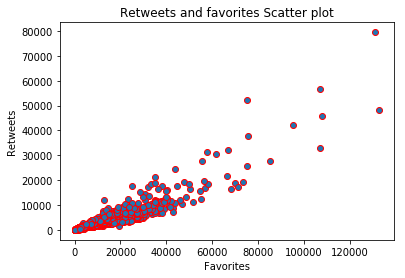

In [77]:
plt.scatter(df['favorite_count'], df['retweet_count'],edgecolors='red')
plt.xlabel('Favorites')
plt.ylabel('Retweets')
plt.title('Retweets and favorites Scatter plot')
plt.savefig('retweet_favorite.png');

In [78]:
count_dogs = df.groupby('dog_stage')['tweet_id'].count()
count_dogs

dog_stage
doggo             54
doggo,floofer      1
doggo,pupper       7
doggo,puppo        1
floofer            7
pupper           166
puppo             21
Name: tweet_id, dtype: int64

In [79]:
df.name.value_counts().nlargest(10)

Lucy       10
Cooper     10
Charlie    10
Tucker      9
Oliver      9
Penny       8
Sadie       7
Daisy       7
Winston     7
Lola        6
Name: name, dtype: int64

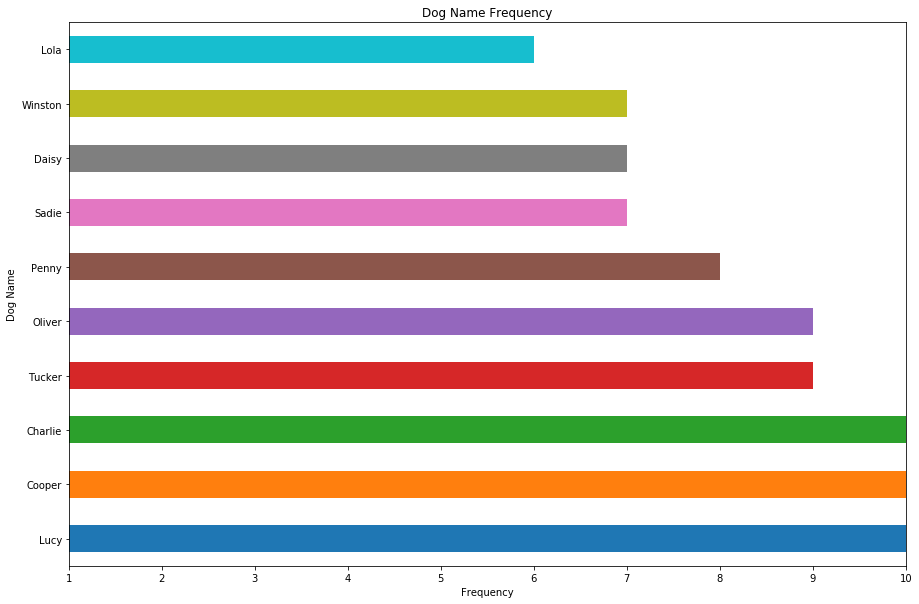

In [80]:
plt.subplots(figsize=(15, 10))
df.name.value_counts().nlargest(10).plot(kind = 'barh');
plt.title('Dog Name Frequency');
plt.xlabel('Frequency');
plt.ylabel('Dog Name');
plt.xlim(1, 10);
plt.savefig('dog_name.png');

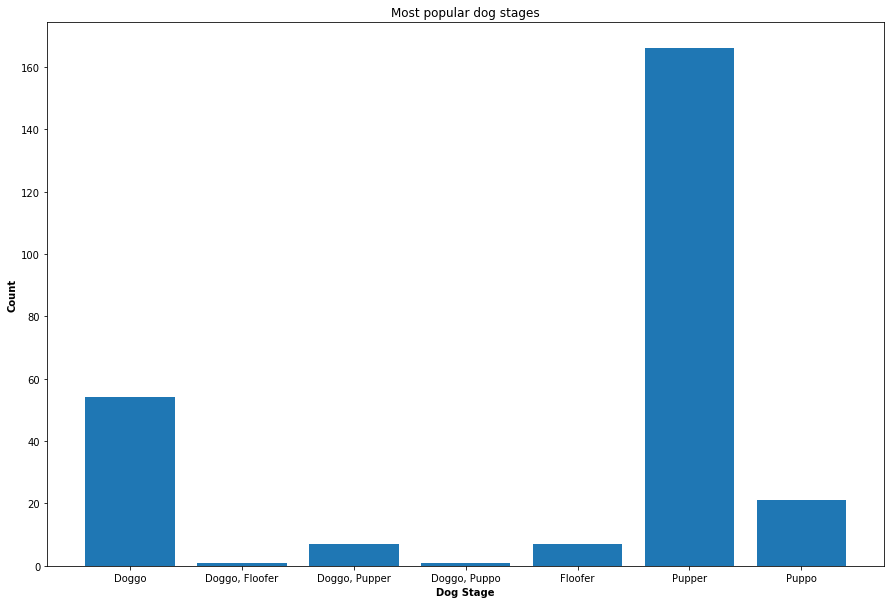

In [81]:
plt.subplots(figsize=(15, 10))
plt.bar([1, 2, 3, 4, 5, 6, 7], count_dogs, tick_label=['Doggo', 'Doggo, Floofer', 'Doggo, Pupper', 'Doggo, Puppo', 
                                                       'Floofer','Pupper', 'Puppo'])
plt.title('Most popular dog stages')
plt.xlabel('Dog Stage', weight='bold')
plt.ylabel('Count', weight='bold')
plt.savefig('most_pop_types.png');

### Second insight
* Most dog in the datset is `golden_retriever`

In [82]:
df['dog_type'].value_counts()

golden_retriever                  153
Labrador_retriever                103
Pembroke                           94
Chihuahua                          89
pug                                62
toy_poodle                         50
chow                               47
Samoyed                            42
Pomeranian                         41
malamute                           33
Chesapeake_Bay_retriever           31
French_bulldog                     31
cocker_spaniel                     30
miniature_pinscher                 24
Eskimo_dog                         22
German_shepherd                    21
Cardigan                           21
Shih-Tzu                           20
beagle                             20
Staffordshire_bullterrier          20
Siberian_husky                     19
Shetland_sheepdog                  18
Rottweiler                         18
Maltese_dog                        18
Lakeland_terrier                   17
kuvasz                             17
Italian_grey

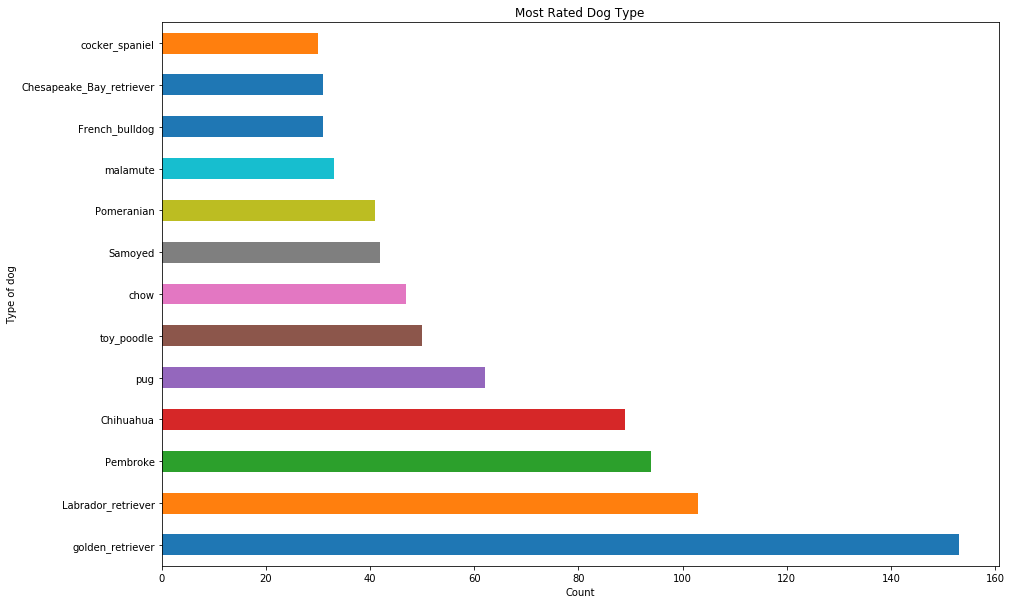

In [83]:
df_dog_type = df.groupby('dog_type').filter(lambda x: len(x) >= 25)
plt.subplots(figsize=(15, 10))
df_dog_type['dog_type'].value_counts().plot(kind = 'barh')
plt.title('Most Rated Dog Type')
plt.xlabel('Count')
plt.ylabel('Type of dog')

fig = plt.gcf() 
fig.savefig('output.png',bbox_inches='tight');

### Third insight

In [84]:
df_dog_type_count = df.groupby('dog_type').count()
df_dog_type_count

,tweet_id,timestamp,source,text,expanded_urls,numerator,denominator,name,dog_stage,jpg_url,p_confidence,retweet_count,favorite_count,rating
dog_type,,,,,,,,,,,,,,
Afghan_hound,3,3,3,3,3,3,3,3,0,3,3,3,3,3
Airedale,12,12,12,12,12,12,12,9,1,12,12,12,12,12
American_Staffordshire_terrier,16,16,16,16,16,16,16,11,3,16,16,16,16,16
Appenzeller,2,2,2,2,2,2,2,1,0,2,2,2,2,2
Australian_terrier,2,2,2,2,2,2,2,2,0,2,2,2,2,2
Bedlington_terrier,6,6,6,6,6,6,6,3,2,6,6,6,6,6
Bernese_mountain_dog,11,11,11,10,11,11,11,10,2,11,11,11,11,11
Blenheim_spaniel,10,10,10,9,10,10,10,8,2,10,10,10,10,10
Border_collie,12,12,12,12,12,12,12,10,4,12,12,12,12,12


In [85]:
df_dog_type_mean = df.groupby('dog_type').mean()
df_dog_type_mean

,tweet_id,numerator,denominator,p_confidence,retweet_count,favorite_count,rating
dog_type,,,,,,,
Afghan_hound,8.041621e+17,9.666667,10.0,0.433959,5976.000000,17326.666667,0.966667
Airedale,7.184489e+17,9.833333,10.0,0.583771,1393.750000,5280.833333,0.983333
American_Staffordshire_terrier,7.597284e+17,10.312500,10.0,0.527359,2310.812500,9380.187500,1.031250
Appenzeller,7.939334e+17,11.000000,10.0,0.503665,1458.000000,7317.500000,1.100000
Australian_terrier,7.785921e+17,11.500000,10.0,0.307584,3078.500000,11127.500000,1.150000
Bedlington_terrier,7.843395e+17,10.333333,10.0,0.286043,7510.166667,21153.166667,1.033333
Bernese_mountain_dog,7.570201e+17,11.272727,10.0,0.766685,1616.545455,7284.000000,1.127273
Blenheim_spaniel,7.404407e+17,11.100000,10.0,0.699588,2583.300000,9280.900000,1.110000
Border_collie,7.457945e+17,10.583333,10.0,0.576845,2207.750000,8933.083333,1.058333


In [86]:
dog_type_count = df_dog_type_count['rating']
dog_type_count

dog_type
Afghan_hound                        3
Airedale                           12
American_Staffordshire_terrier     16
Appenzeller                         2
Australian_terrier                  2
Bedlington_terrier                  6
Bernese_mountain_dog               11
Blenheim_spaniel                   10
Border_collie                      12
Border_terrier                      7
Boston_bull                        12
Bouvier_des_Flandres                1
Brabancon_griffon                   3
Brittany_spaniel                    8
Cardigan                           21
Chesapeake_Bay_retriever           31
Chihuahua                          89
Dandie_Dinmont                      7
Doberman                            9
English_setter                      8
English_springer                   10
EntleBucher                         1
Eskimo_dog                         22
French_bulldog                     31
German_shepherd                    21
German_short-haired_pointer         8
Gor

In [87]:
dog_type_mean = df_dog_type_mean['rating']
dog_type_mean

dog_type
Afghan_hound                      0.966667
Airedale                          0.983333
American_Staffordshire_terrier    1.031250
Appenzeller                       1.100000
Australian_terrier                1.150000
Bedlington_terrier                1.033333
Bernese_mountain_dog              1.127273
Blenheim_spaniel                  1.110000
Border_collie                     1.058333
Border_terrier                    1.214286
Boston_bull                       0.941667
Bouvier_des_Flandres              1.300000
Brabancon_griffon                 1.000000
Brittany_spaniel                  1.037500
Cardigan                          1.114286
Chesapeake_Bay_retriever          1.083871
Chihuahua                         1.053933
Dandie_Dinmont                    0.957143
Doberman                          1.133333
English_setter                    0.987500
English_springer                  1.050000
EntleBucher                       1.100000
Eskimo_dog                        1.140909
Fr

In [88]:
df = pd.DataFrame()
df['dog_type_count'] = dog_type_count
df['dog_type_mean'] = dog_type_mean
df

,dog_type_count,dog_type_mean
dog_type,,
Afghan_hound,3,0.966667
Airedale,12,0.983333
American_Staffordshire_terrier,16,1.031250
Appenzeller,2,1.100000
Australian_terrier,2,1.150000
Bedlington_terrier,6,1.033333
Bernese_mountain_dog,11,1.127273
Blenheim_spaniel,10,1.110000
Border_collie,12,1.058333


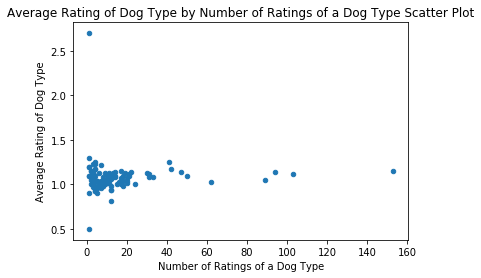

In [89]:
df.plot(x='dog_type_count', y='dog_type_mean', kind='scatter')
plt.xlabel('Number of Ratings of a Dog Type')
plt.ylabel('Average Rating of Dog Type')
plt.title('Average Rating of Dog Type by Number of Ratings of a Dog Type Scatter Plot')

fig = plt.gcf()
#plt.savefig('X:/' + newName + '.png', 
fig.savefig('output2.png',bbox_inches='tight');